# 1. Autoencoder

## 1.1. Подготовка данных


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os
import pandas as pd
import skimage.io
from skimage.transform import resize

In [ ]:
from tqdm.notebook import tqdm_notebook

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def toFixed(x, digits=0):
    return f"{x:.{digits}f}"

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

In [ ]:
all_photos, all_attrs = fetch_dataset()

In [ ]:
all_photos.shape, all_attrs.shape

((13143, 64, 64, 3), (13143, 73))

In [ ]:
all_attrs.head(2)

Male     Asian     White     Black      Baby     Child     Youth  \
0  1.568346 -1.889043  1.737203 -0.929729 -1.471799  -0.19558 -0.835609   
1  0.169851 -0.982408  0.422709 -1.282184  -1.36006 -0.867002 -0.452293   

  Middle Aged    Senior Black Hair  ... Pale Skin 5 o' Clock Shadow  \
0   -0.351468 -1.012533  -0.719593  ...  0.361738          1.166118   
1   -0.197521 -0.956073  -0.802107  ... -0.832036          -0.39768   

  Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
0               -1.164916         -1.13999    -2.371746       -1.299932   
1                 0.87416        -0.945431    -0.268649       -0.006244   

  Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  
0  -0.414682        -1.144902        0.694007        -0.826609  
1  -0.030406        -0.480128         0.66676        -0.496559  

[2 rows x 73 columns]


Разбиваю выборку картинок на train и val

In [ ]:
all_photos_torch = torch.FloatTensor(np.rollaxis(all_photos, 3, 1))

In [ ]:
train_photos, test_photos = train_test_split(all_photos_torch, test_size=0.1, random_state=42, shuffle=True)

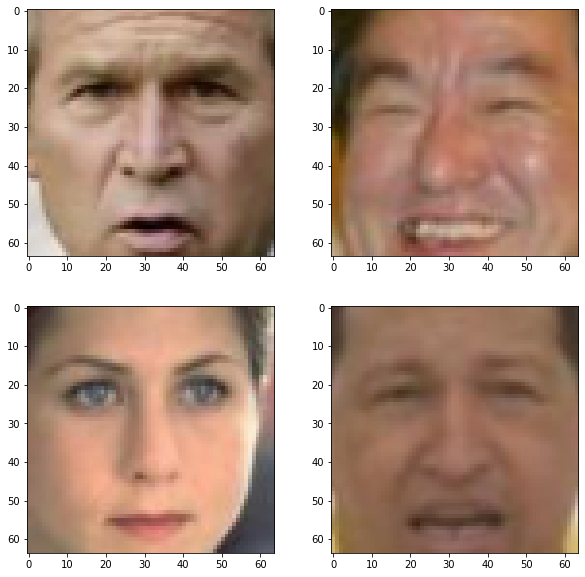

In [ ]:
plt.figure(figsize=(10, 10))
for i, img in enumerate(train_photos[np.random.choice(train_photos.shape[0], 4)]):
  plt.subplot(2, 2, i+1)
  plt.imshow(img.permute(1, 2, 0))

## 1.2. Архитектура модели
автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">

In [ ]:
dim_code = 32 #размер латентного вектора

**Релизую архитектуру свёрточного автоэнкодера**

In [ ]:
from copy import deepcopy

In [ ]:
# define a simple linear VAE
class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.flatten = nn.Flatten()
 
      self.encoder = nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=7, padding=3),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Conv2d(8, 16, kernel_size=7, padding=3),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(16 * 64 * 64, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, dim_code)
      )

      self.decoder = nn.Sequential(
        nn.Linear(dim_code, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        nn.Linear(2048, 3 * 62 * 62),
        nn.Sigmoid() #because any pixpels must be in [0, 1]
      )

      self.conv_t = nn.ConvTranspose2d(3, 3, kernel_size=3)
 
    def forward(self, x):
        # encoding
        x = x.float()
        x = self.encoder(x)

        #decoding
        x = self.decoder(x)
        x = x.view(-1, 3, 62, 62)
        x = F.relu(self.conv_t(x))
        reconstruction = torch.sigmoid(x)

        return reconstruction

    def decode(self, x):
      x = self.decoder(x)
      x = x.view(-1, 3, 62, 62)
      x = F.relu(self.conv_t(x))
      reconstruction = torch.sigmoid(x)
      return reconstruction

    def get_latent_vector(self, x):
        latent_vector = self.encoder(x)
        return latent_vector

In [ ]:
from torchsummary import summary

In [ ]:
summary(a.cuda(), input_size=(3, 64, 64), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [16, 8, 64, 64]           1,184
       BatchNorm2d-2            [16, 8, 64, 64]              16
              ReLU-3            [16, 8, 64, 64]               0
            Conv2d-4           [16, 16, 64, 64]           6,288
       BatchNorm2d-5           [16, 16, 64, 64]              32
              ReLU-6           [16, 16, 64, 64]               0
           Flatten-7                [16, 65536]               0
            Linear-8                  [16, 512]      33,554,944
       BatchNorm1d-9                  [16, 512]           1,024
             ReLU-10                  [16, 512]               0
           Linear-11                  [16, 256]         131,328
      BatchNorm1d-12                  [16, 256]             512
             ReLU-13                  [16, 256]               0
           Linear-14                  [

## 1.3 Обучение

In [ ]:
criterion = F.mse_loss
#criterion = nn.BCELoss()

In [ ]:
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=256, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_photos, batch_size=256, drop_last=True)

In [ ]:
n_epochs = 100

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

In [ ]:
autoencoder = Autoencoder()
optimizer = torch.optim.Adam(autoencoder.parameters())
autoencoder = autoencoder.to(device)

In [ ]:
val_losses, train_losses = [], []

In [ ]:
for x_batch, batch in zip(train_loader, test_loader):
  print(x_batch.shape, batch.shape)
  break

torch.Size([256, 3, 64, 64]) torch.Size([256, 3, 64, 64])


In [ ]:
for i in range(n_epochs):
  print('epoch:', i+1)

  #ОБУЧЕНИЕ
  autoencoder.train()
  train_losses_per_epoch = []

  for x_batch in tqdm_notebook(train_loader):
    optimizer.zero_grad()

    reconstruction = autoencoder(x_batch.to(device))
    reconstruction = reconstruction.view(-1, 3, 64, 64)
    loss = criterion(reconstruction, x_batch.to(device))
    train_losses_per_epoch += [loss.item()]

    loss.backward()
    optimizer.step()
  
  print('train_loss:', toFixed(np.mean(train_losses_per_epoch), 6))
  train_losses += [np.mean(train_losses_per_epoch)]
  
  #ВАЛИДАЦИЯ
  autoencoder.eval()
  val_losses_per_epoch = []
  with torch.no_grad():
    for x_batch in test_loader:
      reconstruction = autoencoder(x_batch.to(device))
      reconstruction = reconstruction.view(-1, 3, 64, 64)

      loss = criterion(reconstruction, x_batch.to(device))
      val_losses_per_epoch += [loss.item()]
  
  print('val_loss:', toFixed(np.mean(val_losses_per_epoch), 6))
  val_losses += [np.mean(val_losses_per_epoch)]
  if(val_losses[-1] < 0.027) & (train_losses[-1] < 0.0265):
    print(train_losses[-1], val_losses[-1])
    break

epoch: 1


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.035724
val_loss: 0.033227
epoch: 2


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.030914
val_loss: 0.030192
epoch: 3


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.029645
val_loss: 0.029417
epoch: 4


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.028997
val_loss: 0.028754
epoch: 5


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.028622
val_loss: 0.028554
epoch: 6


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.028332
val_loss: 0.028327
epoch: 7


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.028079
val_loss: 0.028343
epoch: 8


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.027883
val_loss: 0.028162
epoch: 9


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.027707
val_loss: 0.027932
epoch: 10


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.027538
val_loss: 0.027645
epoch: 11


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.027400
val_loss: 0.027544
epoch: 12


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.027285
val_loss: 0.027645
epoch: 13


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.027191
val_loss: 0.027654
epoch: 14


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.027123
val_loss: 0.027443
epoch: 15


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.027054
val_loss: 0.027463
epoch: 16


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026981
val_loss: 0.027311
epoch: 17


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026909
val_loss: 0.027509
epoch: 18


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026855
val_loss: 0.027398
epoch: 19


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026822
val_loss: 0.027224
epoch: 20


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026775
val_loss: 0.027354
epoch: 21


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026710
val_loss: 0.027508
epoch: 22


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026648
val_loss: 0.027426
epoch: 23


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026594
val_loss: 0.027312
epoch: 24


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026552
val_loss: 0.027284
epoch: 25


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026521
val_loss: 0.027274
epoch: 26


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026497
val_loss: 0.027181
epoch: 27


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026471
val_loss: 0.027169
epoch: 28


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026445
val_loss: 0.027066
epoch: 29


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026405
val_loss: 0.027071
epoch: 30


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026359
val_loss: 0.027144
epoch: 31


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026330
val_loss: 0.027425
epoch: 32


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026326
val_loss: 0.027509
epoch: 33


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026320
val_loss: 0.027107
epoch: 34


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026288
val_loss: 0.027009
epoch: 35


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026239
val_loss: 0.027035
epoch: 36


  0%|          | 0/46 [00:00<?, ?it/s]

train_loss: 0.026208
val_loss: 0.026964
0.026207664374100124 0.02696361914277077


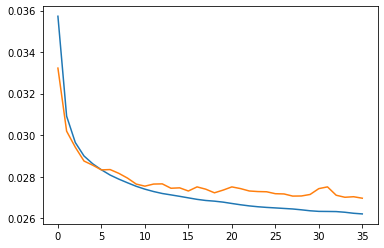

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)

Смотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
def get_reconstruction(model, val_loader):
  model.eval()
  with torch.no_grad():
    for batch in val_loader:
      reconstruction = model(batch.to(device))
      reconstruction = reconstruction.view(-1, 3, 64, 64)
      result = reconstruction.cpu().detach().numpy()
      ground_truth = batch.numpy()
      break

  return ground_truth, result

In [ ]:
def plot_reconstruction(model, ground_truth, result, cnt):
  plt.figure(figsize=(16, 20))
  for i, (gt, res) in enumerate(zip(ground_truth[:cnt], result[:cnt])):
    plt.subplot(cnt, 2, 2*i+1)
    plt.imshow(torch.FloatTensor(gt).permute(1, 2, 0).numpy())
    plt.subplot(cnt, 2, 2*i+2)
    plt.imshow(torch.FloatTensor(res).permute(1, 2, 0).numpy())

In [ ]:
gr, res = get_reconstruction(autoencoder, test_loader)

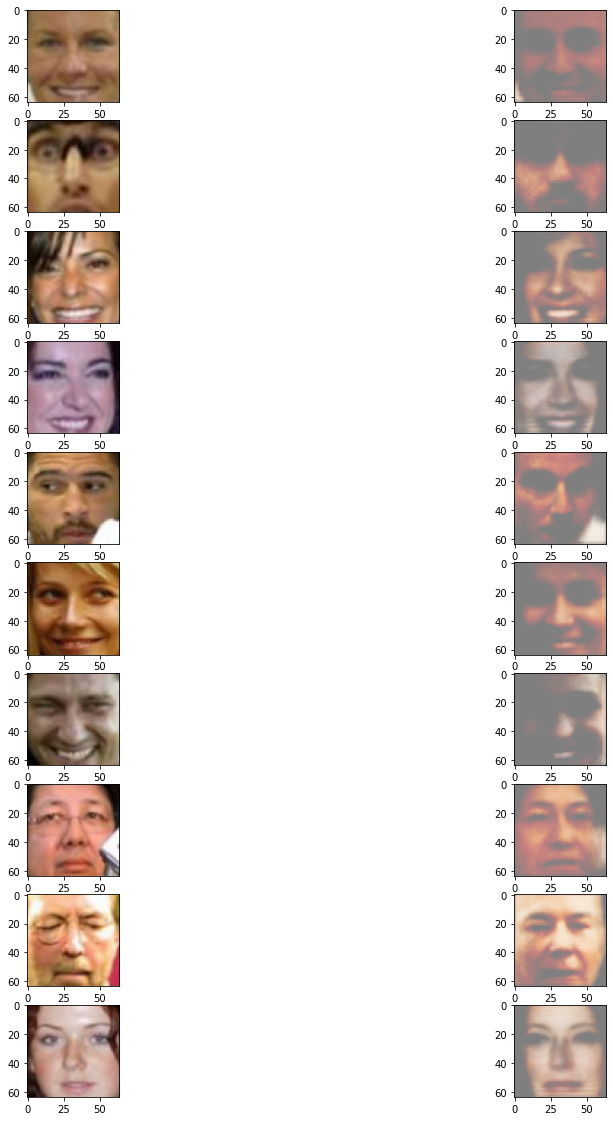

In [ ]:
plot_reconstruction(autoencoder, gr, res, 10)

## 1.4. Sampling

дадим декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

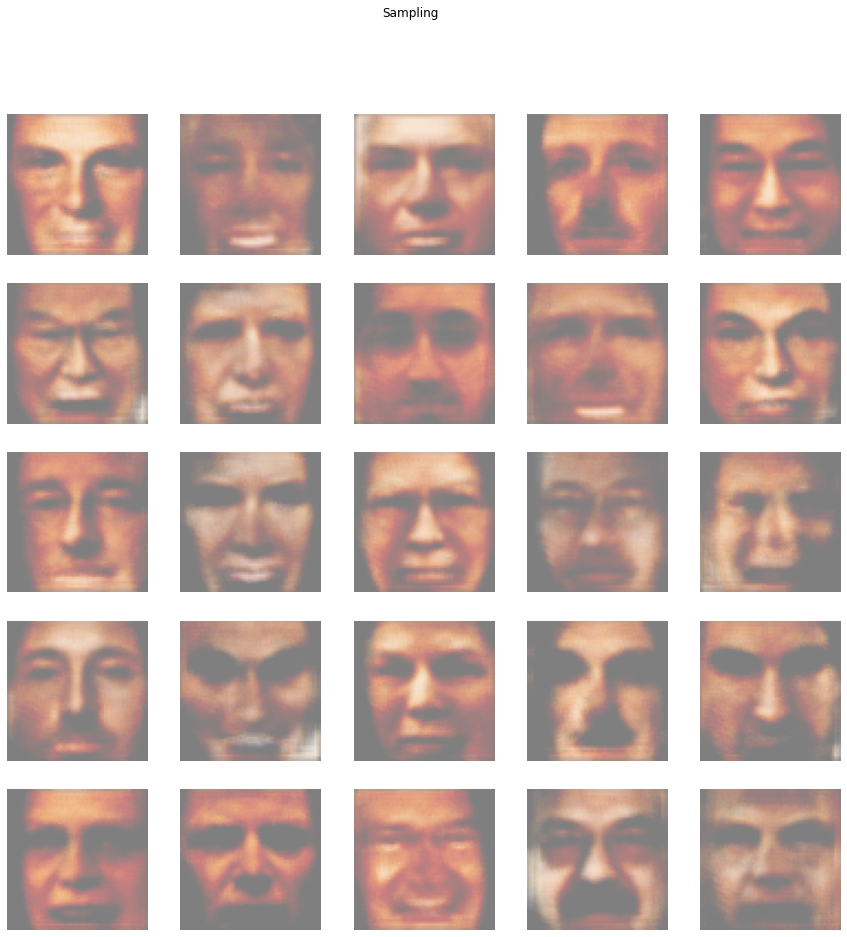

In [ ]:
z = torch.FloatTensor(np.random.randn(25, dim_code)).to(device)
output = autoencoder.decode(autoencoder.decoder(z)).detach().cpu().view(-1, 3, 64, 64).numpy()
plt.figure(figsize=(15, 15))

for i in range(25):
 plt.subplot(5, 5, i + 1)
 plt.imshow(np.rollaxis(output[i], 0, 3))
 plt.axis('off')
plt.suptitle("Sampling")
plt.show()

## Time to make fun!

пририсовываю людям улыбки

План:

1. выделяем "вектор улыбки": для этого из выборки изображений возьмём несколько (~15) людей с улыбками и столько же без.

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустных

3. Вычисляем вектор улыбки -- посчитаем разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже весёлого!

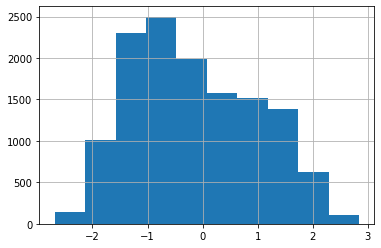

In [ ]:
all_attrs['Smiling'].hist()

**весёлые люди**

In [ ]:
idx_smile = np.where(all_attrs['Smiling'] > 2.5)[0]
idx_smile.shape

(37,)

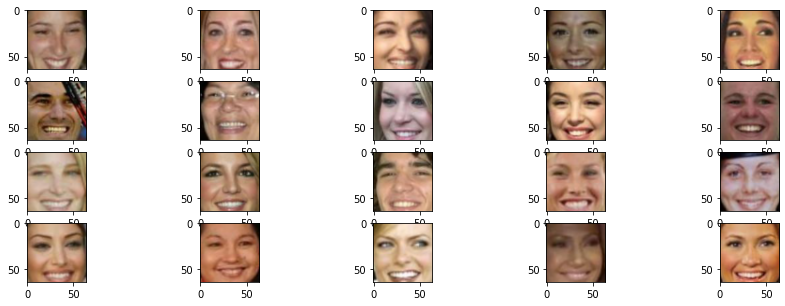

In [ ]:
plt.figure(figsize=(15, 5))

for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.imshow(all_photos[idx_smile[i]])

**грустные люди**

In [ ]:
idx_sad = np.where(all_attrs['Smiling'] < -2.4)[0]
idx_sad.shape

(28,)

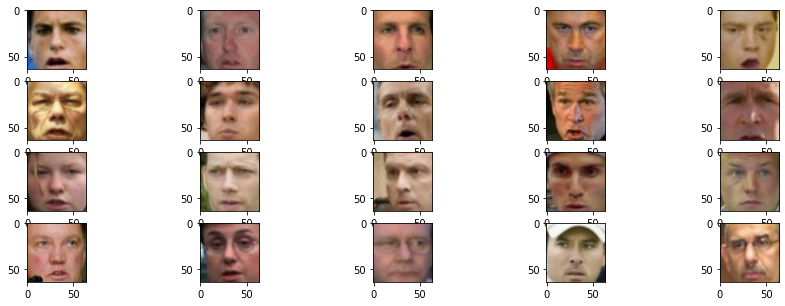

In [ ]:
plt.figure(figsize=(15, 5))

for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.imshow(all_photos[idx_sad[i]])

**получаем латентные векторы и усредняем разность -> вектор улыбки**

In [ ]:
autoencoder.eval()
with torch.no_grad():
  smile_tensor = torch.FloatTensor(np.rollaxis(all_photos[idx_smile[:15]], 3, 1))
  sad_tensor = torch.FloatTensor(np.rollaxis(all_photos[idx_sad[:15]], 3, 1))

  smile_people_v = autoencoder.encoder(smile_tensor.to(device))
  sad_people_v = autoencoder.encoder(sad_tensor.to(device))

  smile_vector = torch.mean(smile_people_v - sad_people_v, axis=0)

**смотрим результат**

In [ ]:
rand_batch = np.rollaxis(all_photos, 3, 1)[np.random.choice(all_photos.shape[0], 6)]

In [ ]:
autoencoder.eval()
with torch.no_grad():
  tmp = torch.FloatTensor(rand_batch).to(device)
  with_smile = autoencoder.decode(autoencoder.get_latent_vector(tmp) + smile_vector)

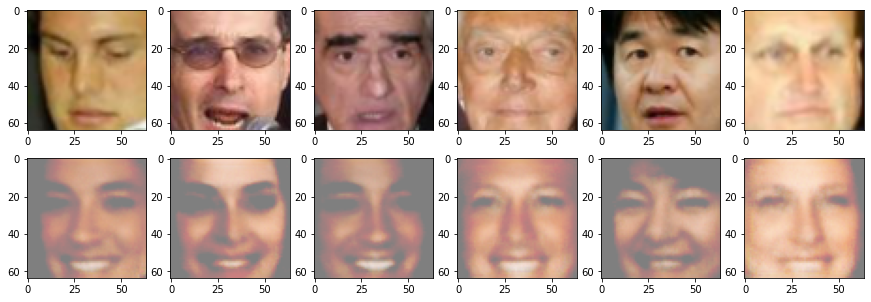

In [ ]:
plt.figure(figsize=(15, 5))
for i in range(6):
  plt.subplot(2, 6, i+1)
  plt.imshow(torch.FloatTensor(rand_batch[i]).permute(1, 2, 0).numpy())
  plt.subplot(2, 6, i+7)
  plt.imshow(with_smile.view(-1, 3, 64, 64)[i].permute(1, 2, 0).cpu().numpy())

#Variational Autoencoder 

**Воспользуемся датасетом MNIST**

In [ ]:
from torchvision import transforms

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение

In [ ]:
features = 32
# define a simple linear VAE
class new_VAE(nn.Module):
    def __init__(self):
        super(new_VAE, self).__init__()

        self.flatten = nn.Flatten()
 
        # encoder
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(16*24*24, 512)
        self.bn3 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 128)
        self.bn4 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, features*2)
 
        # decoder 
        self.dec_fc1 = nn.Linear(features, 128)
        self.dec_bn1 = nn.BatchNorm1d(128)

        self.dec_fc2 = nn.Linear(128, 512)
        self.dec_bn2 = nn.BatchNorm1d(512)

        self.dec_fc3 = nn.Linear(512, 2048)
        self.dec_bn3 = nn.BatchNorm1d(2048)

        self.dec_fc4 = nn.Linear(2048, 1*28*28)



    def encoder(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))

        x = x.view(-1, 16*24*24)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def decoder(self, x):
        x = F.relu(self.dec_bn1(self.dec_fc1(x)))
        x = F.relu(self.dec_bn2(self.dec_fc2(x)))
        x = F.relu(self.dec_bn3(self.dec_fc3(x)))
        x = self.dec_fc4(x).view(-1, 1, 28, 28)
        return x


    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = x.float()
        x = self.encoder(x)
        x = x.view(-1, 2, features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        #decoding
        x = self.decoder(z)

        reconstruction = torch.sigmoid(x)
        return reconstruction, mu, log_var

    def sample(self, z):
        generated = self.decoder(z)
        generated = torch.sigmoid(generated)
        generated = generated.view(-1, 1, 28, 28)
        return generated

    def get_latent_vector(self, x):
        x = x.float()
        x, idxs = self.encoder(x)
        x = x.view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        return z

Определим лосс и его компоненты для VAE:

лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

обучим модель:

In [ ]:
epochs=40

In [ ]:
criterion = loss_vae

In [ ]:
vaue = new_VAE()

opt = torch.optim.Adam(vaue.parameters())

vaue.to(device)

In [ ]:
for i in train_loader:
  print(i[0].shape, i[1].shape)
  break

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [ ]:
train_losses, val_losses = [], []

**цикл обучения**

In [ ]:
for i in range(epochs):
  print('epoch:', i+1)

  #ОБУЧЕНИЕ
  vaue.train()
  train_losses_per_epoch = []

  for x_batch in tqdm_notebook(train_loader):
    opt.zero_grad()
    reconstruction, mu, logsigma = vaue(x_batch[0].to(device))

    loss = criterion(x_batch[0].to(device), mu, logsigma, reconstruction)
    train_losses_per_epoch += [loss.item()]

    loss.backward()
    opt.step()
  
  print('train_loss:', toFixed(np.mean(train_losses_per_epoch), 6))
  train_losses += [np.mean(train_losses_per_epoch)]
  
  #ВАЛИДАЦИЯ
  vaue.eval()
  val_losses_per_epoch = []
  with torch.no_grad():
    for x_batch in test_loader:
      reconstruction, mu, logsigma = vaue(x_batch[0].to(device))

      loss = criterion(x_batch[0].to(device), mu, logsigma, reconstruction)
      
      val_losses_per_epoch += [loss.item()]
  
  print('val_loss:', toFixed(np.mean(val_losses_per_epoch), 6))
  val_losses += [np.mean(val_losses_per_epoch)]

In [ ]:
def plot_losses(train_losses, val_losses, a=12, b=10, name='VAE loss'):
  plt.figure(figsize=(a, b))
  plt.title('VAE loss')
  plt.grid(True)
  plt.plot(train_losses, color='blue', label='train')
  plt.plot(val_losses, color='orange', label='val')
  plt.legend()
  plt.show()

**размерность латентного пространства - 32**

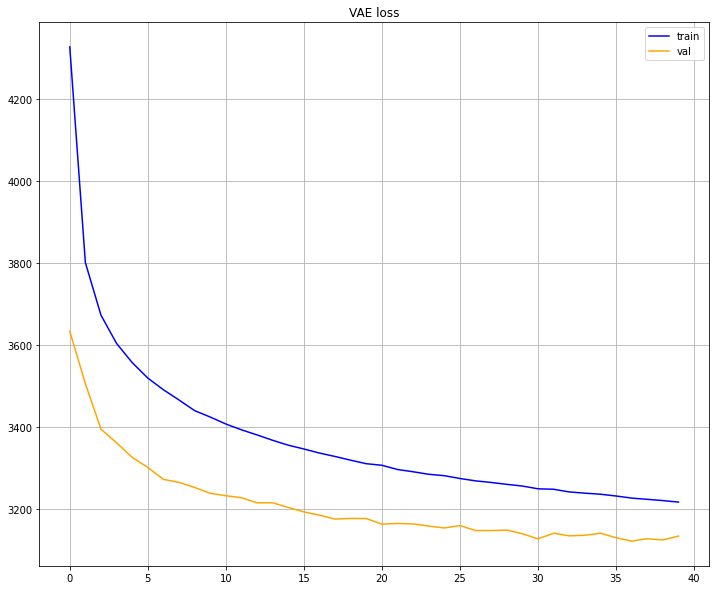

In [ ]:
plot_losses(train_losses, val_losses)

**размерность латентного пространства - 64**

лосс оказался даже чуть выше, чем при 32

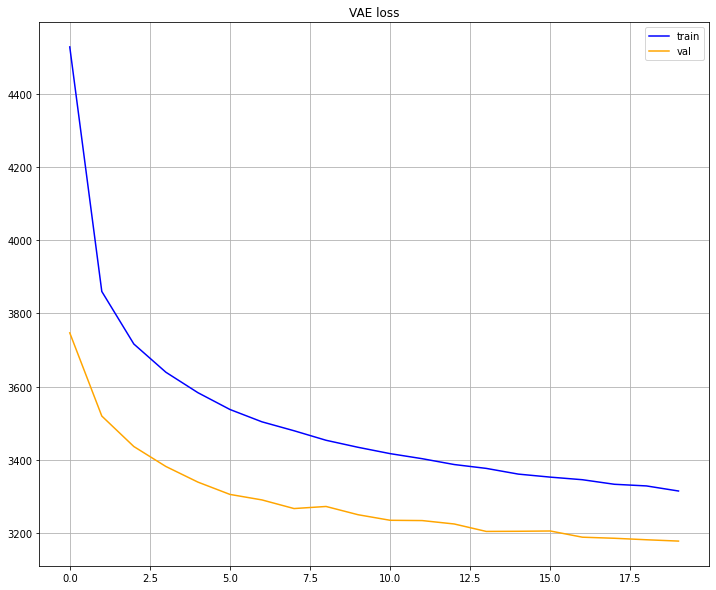

In [ ]:
plot_losses(train_losses, val_losses)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
def get_reconstruction_vae(model, val_loader):
  model.eval()
  with torch.no_grad():
    for batch in val_loader:
      reconstruction, _, _ = model(batch[0].to(device))
      reconstruction = reconstruction.view(-1, 1, 28, 28)
      result = reconstruction.cpu().detach().numpy()
      ground_truth = batch[0].numpy()
      break

  return ground_truth, result

In [ ]:
def plot_reconstruction_vae(model, ground_truth, result, cnt):
  plt.figure(figsize=(16, 8))
  for i, (gt, res) in enumerate(zip(ground_truth[:cnt], result[:cnt])):
    plt.subplot(2, cnt, i+1)
    plt.imshow(gt[0])
    plt.subplot(2, cnt, i+cnt+1)
    plt.imshow(res[0])

In [ ]:
gr_vae, res_vae = get_reconstruction_vae(vaue, test_loader)

**видно, что изображения восстанавливаются хорошо**

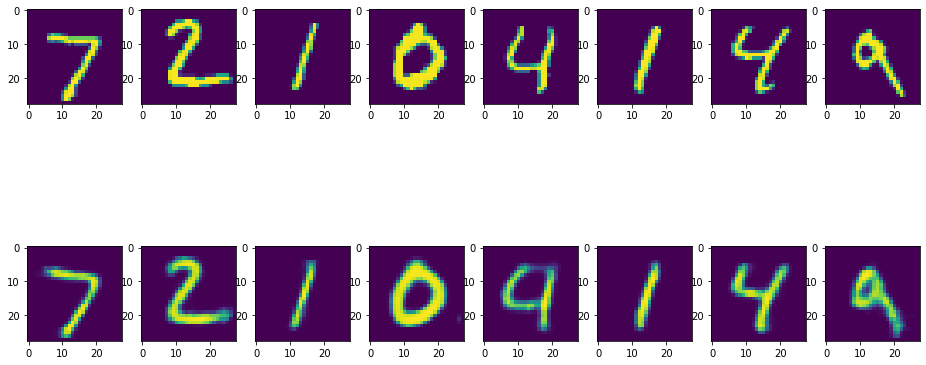

In [ ]:
plot_reconstruction_vae(vaue, gr_vae, res_vae, cnt=8)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 32) for i in range(10)])

vaue.eval()
with torch.no_grad():
  output = vaue.sample(torch.FloatTensor(z).to(device))

In [ ]:
output = output.cpu().numpy()

**получившиеся картинки**

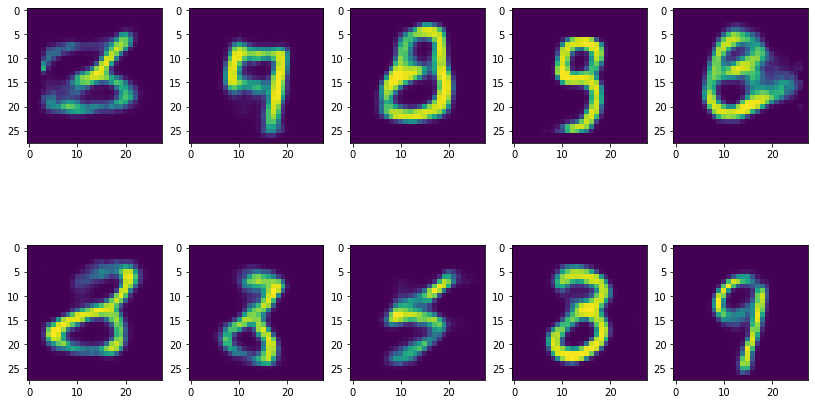

In [ ]:
plt.figure(figsize=(14, 8))

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(output[i][0])

## 2.2. Latent Representation

План:

1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` сжать эти представления до размерности 2
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`

In [ ]:
test_dataset.data[:, None, :, :].shape

torch.Size([10000, 1, 28, 28])

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
vaue.eval()

tmp = vaue.encoder(test_dataset.data[:, None, :, :].float().to(device))
mu = tmp.view(-1, 2, features)[:, 0, :] #на этапе вычисления выдаём уже детерминированные значение

latent_vectors = mu
#logsigma = tmp.view(-1, 2, features)[:, 1, :]

In [ ]:
latent_vectors.detach().cpu().numpy().shape

(10000, 32)

In [ ]:
idx_inf = np.where(np.isinf(latent_vectors.detach().cpu().numpy()) == True)
latent_vectors[idx_inf]

tensor([], device='cuda:0', grad_fn=<IndexBackward0>)

In [ ]:
latent_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)

In [ ]:
points = latent_embedded.fit_transform(latent_vectors.detach().cpu().numpy())

**результат**

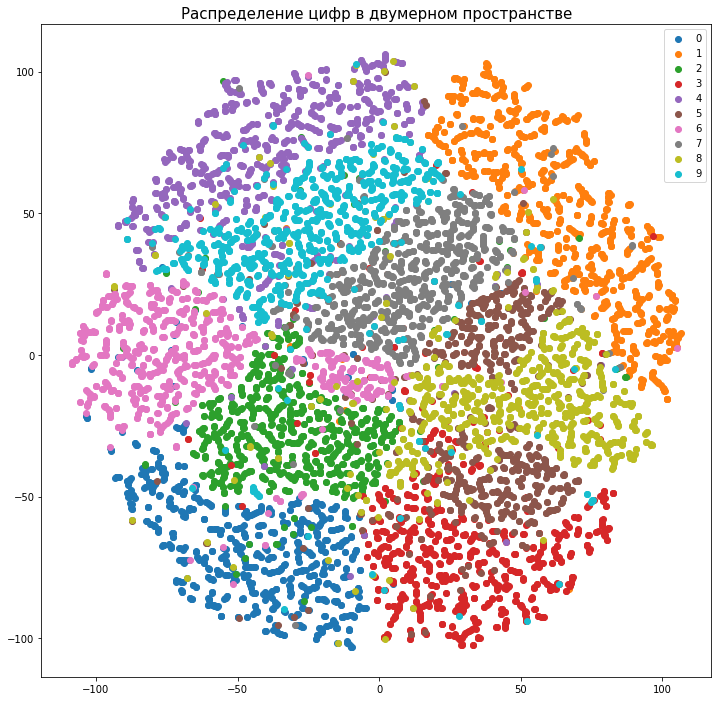

In [ ]:
plt.figure(figsize=(12, 12))
plt.title('Распределение цифр в двумерном пространстве', fontsize=15)

for i in range(10):
  class_idxes = np.where(test_dataset.targets == i)
  plt.scatter(points[:, 0][class_idxes], points[:, 1][class_idxes], label=i)
plt.legend()
plt.show()

**Кластеры чётко проглядываются, метод tsne и автоэнкодер отработали хорошо**

## 2.3. Conditional VAE


на случай, если захочется сгенерировать определённую цифру, немного изменим архитектуру обычного VAE. При обучении будем подавать в декодер ещё и информацию о классе. Таким образом, в дальнейшем во время генерации будет возможность подать автоэнкодеру информацию о классе цифры, которую мы хотим сгенерировать и получить именно её, а не что-то рандомное от 0 до 9.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



In [ ]:
features = 32
num_classes = 10

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
      #определите архитектуры encoder и decoder
      super(CVAE, self).__init__()

      self.conv = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=3),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Conv2d(8, 16, kernel_size=3),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Flatten()
      )

      self.encoder = nn.Sequential(
        nn.Linear(16 * 24 * 24, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, features*2)
      )

      self.decoder = nn.Sequential(
        nn.Linear(features + num_classes, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        nn.Linear(2048, 1 * 28 * 28),
        nn.Sigmoid() #because any pixpels must be in [0, 1]
      )

    def encode(self, x, class_num):
        #реализуйте forward проход энкодера
        tmp = self.encoder(self.conv(x))
        tmp = tmp.view(-1, 2, features)

        mu = tmp[:, 0, :]
        logsigma = tmp[:, 1, :]
        class_num_onehot = F.one_hot(torch.Tensor(class_num).to(torch.int64), num_classes)

        return mu, logsigma, class_num_onehot
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample 
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num_onehot):
        #print(z.shape)
        #print(class_num_onehot.shape)
        new_latent_vector = torch.cat([z, class_num_onehot], 1)
        return self.decoder(new_latent_vector)

    def forward(self, x, y):
        mu, logsigma, class_num_onehot = self.encode(x, y)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num_onehot)

        return reconstruction, mu, logsigma 

###Обучение

In [ ]:
epochs=20

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
criterion = loss_vae

In [ ]:
cvae = CVAE()

opt = torch.optim.Adam(cvae.parameters())

cvae = cvae.to(device)

In [ ]:
train_losses, val_losses = [], []

In [ ]:
for i in range(epochs):
  print('epoch:', i+1)

  #ОБУЧЕНИЕ
  cvae.train()
  train_losses_per_epoch = []

  for (x_batch, y_batch) in tqdm_notebook(train_loader):
    opt.zero_grad()
    reconstruction, mu, logsigma = cvae(x_batch.to(device), y_batch.to(device))
    reconstruction = reconstruction.view(-1, 1, 28, 28)
    loss = criterion(x_batch.to(device), mu, logsigma, reconstruction)
    train_losses_per_epoch += [loss.item()]

    loss.backward()
    opt.step()
  
  print('train_loss:', toFixed(np.mean(train_losses_per_epoch), 6))
  train_losses += [np.mean(train_losses_per_epoch)]
  
  #ВАЛИДАЦИЯ
  cvae.eval()
  val_losses_per_epoch = []
  with torch.no_grad():
    for (x_batch, y_batch) in test_loader:
      reconstruction, mu, logsigma = cvae(x_batch.to(device), y_batch.to(device))
      reconstruction = reconstruction.view(-1, 1, 28, 28)
      loss = criterion(x_batch.to(device), mu, logsigma, reconstruction)
      
      val_losses_per_epoch += [loss.item()]
  
  print('val_loss:', toFixed(np.mean(val_losses_per_epoch), 6))
  val_losses += [np.mean(val_losses_per_epoch)]

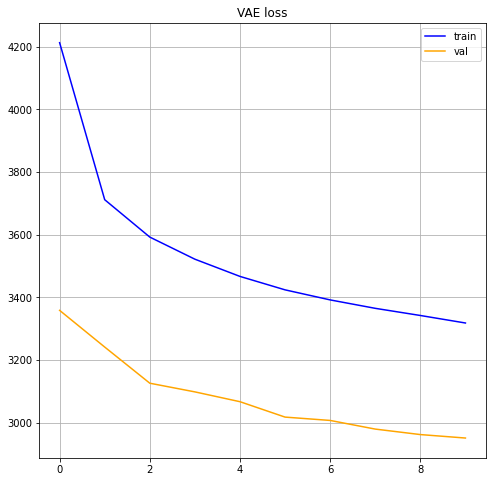

In [ ]:
plot_losses(train_losses[2:], val_losses, a=8, b=8, name='CVAE Loss')

### Sampling


In [ ]:
onehot_5 = F.one_hot(torch.as_tensor(5), 10)
onehot_7 = F.one_hot(torch.as_tensor(7), 10)
onehot_allnum = F.one_hot(torch.as_tensor(np.arange(10)), 10)

In [ ]:
z = np.array([np.random.normal(0, 1, 32) for i in range(5)])
v = np.array([np.random.normal(0, 1, 32) for i in range(10)])

cvae.eval()
with torch.no_grad():
  tmp_5 = np.vstack(np.array([np.array(onehot_5) for i in range(5)]))
  tmp_7 = np.vstack(np.array([np.array(onehot_7) for i in range(5)]))

  output_5 = cvae.decode(torch.FloatTensor(z).to(device), torch.FloatTensor(tmp_5).to(device)).view(-1, 1, 28, 28).cpu().numpy()
  output_7 = cvae.decode(torch.FloatTensor(z).to(device), torch.FloatTensor(tmp_7).to(device)).view(-1, 1, 28, 28).cpu().numpy()
  output_allnum = cvae.decode(torch.FloatTensor(v).to(device), onehot_allnum.to(device)).view(-1, 1, 28, 28).cpu().numpy()

**несколько пятёрок и семёрок**

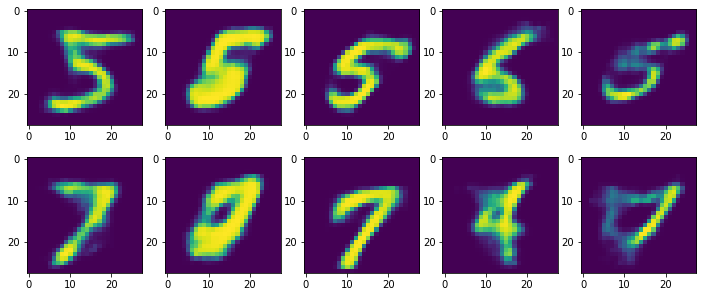

In [ ]:
plt.figure(figsize=(12, 5))

for i in range(5):
  plt.subplot(2, 5, i+1)
  plt.imshow(output_5[i][0])
  plt.subplot(2, 5, i+1+5)
  plt.imshow(output_7[i][0])

**все цифры по порядку: 0, 1, 2 ... 9**

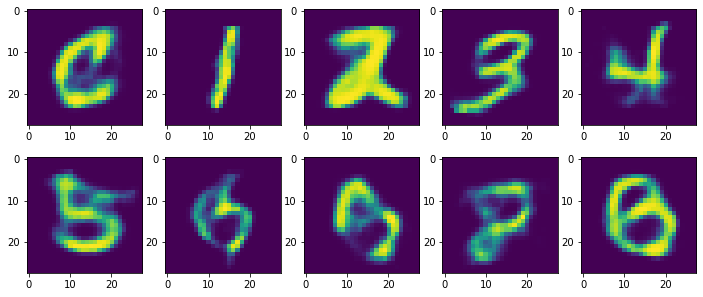

In [ ]:
plt.figure(figsize=(12, 5))

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(output_allnum[i][0])

### Latent Representations

Посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE

In [ ]:
cvae.eval()

mu, _, _ = cvae.encode(test_dataset.data[:, None, :, :].float().to(device), test_dataset.targets)
#mu = tmp.view(-1, 2, features)[:, 0, :] #на этапе вычисления выдаём уже детерминированные значение
latent_vectors = mu

In [ ]:
latent_vectors.detach().cpu().numpy()
latent_cvae_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
points_cvae = latent_cvae_embedded.fit_transform(latent_vectors.detach().cpu().numpy())

**результат**

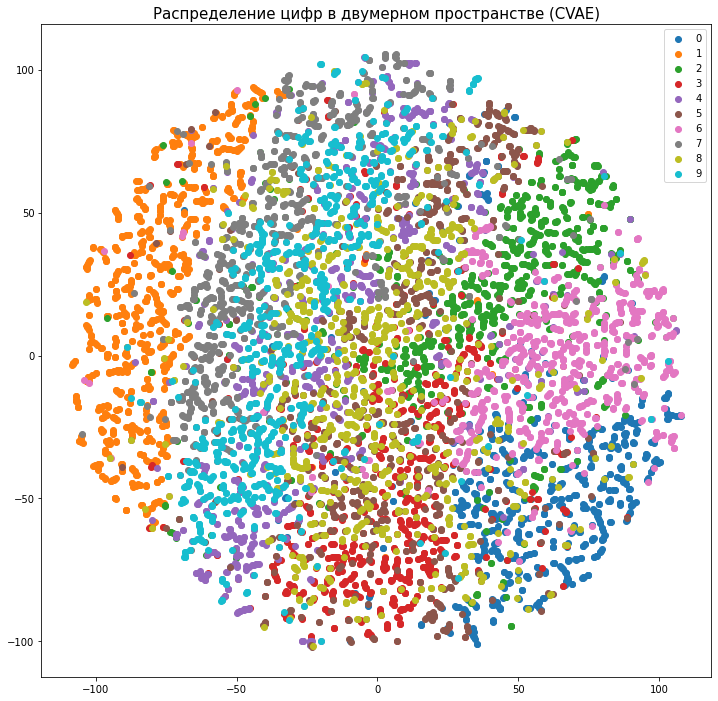

In [ ]:
plt.figure(figsize=(12, 12))
plt.title('Распределение цифр в двумерном пространстве (CVAE)', fontsize=15)

for i in range(10):
  class_idxes = np.where(test_dataset.targets == i)
  plt.scatter(points_cvae[:, 0][class_idxes], points_cvae[:, 1][class_idxes], label=i)
plt.legend()
plt.show()

По сравнению с CVAE, кластеры стали более вытянутыми, переходы между ними стали более размытыми (результат генерации из шума выше это подтверждает)

#Denoising


Используем автоэнкодер для избавления от шума на фотографиях (denoising). Для этого обучим его специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Возьмём исходный датасет с лицами и сделаем копию этого датасета с шумом.

In [ ]:
noise_factor = 0.1 

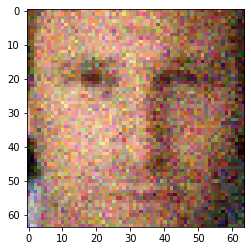

In [ ]:
plt.imshow(all_photos[0] + noise_factor * np.random.normal(0, 1, (64, 64, 3)))
None

In [ ]:
all_photos_noisy = all_photos + noise_factor*np.random.normal(loc=0, scale=1.0, size=all_photos.shape)

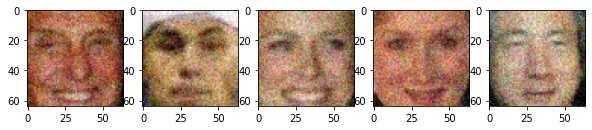

In [ ]:
plt.figure(figsize=(10, 15))
for i, img in enumerate(all_photos_noisy[np.random.choice(all_photos.shape[0], 5)]):
  plt.subplot(1, 5, i+1)
  plt.imshow(img)

**разбиваю на тестовую/тренировочную выборки**

In [ ]:
all_photos_noisy_torch = torch.FloatTensor(np.rollaxis(all_photos_noisy, 3, 1))
train_noisy, test_noisy = train_test_split(all_photos_noisy_torch, test_size=0.1, random_state=42)

In [ ]:
train_noisy_loader = torch.utils.data.DataLoader(train_noisy, batch_size=256)
test_noisy_loader = torch.utils.data.DataLoader(test_noisy, batch_size=256)

**модель**

In [ ]:
dim_code=32

class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.flatten = nn.Flatten()
 
      self.encoder = nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3, padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(16 * 64 * 64, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, dim_code)
      )

      self.decoder = nn.Sequential(
        nn.Linear(dim_code, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        #nn.Linear(2048, 16 * 12 * 12),
        nn.Linear(2048, 3 * 62 * 62)
        #nn.Sigmoid() #because any pixpels must be in [0, 1]
      )

      #self.conv_trans_0 = nn.ConvTranspose2d(16, 8, kernel_size=3)
      self.conv_trans_0 = nn.ConvTranspose2d(4, 16, kernel_size=3)
      self.conv_trans_1 = nn.ConvTranspose2d(16, 8, kernel_size=3)
      self.conv_trans_2 = nn.ConvTranspose2d(3, 3, kernel_size=3)

      self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear')
      self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
      self.conv = nn.Conv2d(3, 3, kernel_size=3)
      #self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
 
    def forward(self, x):
        # encoding
        x = x.float()
        x = self.encoder(x)

        #decoding
        x = self.decoder(x)
        x = x.view(-1, 3, 62, 62)
        #x = F.relu(self.conv_trans_0(x))
        #x = F.relu(self.conv_trans_1(self.upsample0(x)))
        #x = F.relu(self.conv_trans_2(self.upsample1(x)))
        #x = F.relu(self.conv_trans_2(x))
        #x = F.relu(self.conv_trans_0(x))
        #x = F.relu(self.conv_trans_1(x))
        x = F.relu(self.conv_trans_2(x))
        
        reconstruction = torch.sigmoid(x)

        return reconstruction

    def decode(self, x):
      #x = self.decoder(x)
      #x = x.view(-1, 4, 58, 58)
      #x = F.relu(self.conv_trans_0(x))
      #x = F.relu(self.conv_trans_1(x))
      #x = F.relu(self.conv_trans_2(x))
      return torch.sigmoid(x)

    def get_latent_vector(self, x):
        latent_vector = self.encoder(x)
        return latent_vector

In [ ]:
tmp = nn.Upsample(scale_factor=2, mode='bilinear')

In [ ]:
tmp(torch.randn(1, 8, 31, 31)).shape

torch.Size([1, 8, 62, 62])

**код обучения**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = F.mse_loss
n_epochs=30

In [ ]:
ae_noisy = Autoencoder()
optimizer = torch.optim.Adam(ae_noisy.parameters())
ae_noisy.to(device)

In [ ]:
train_losses, val_losses = [], []

In [ ]:
from IPython.display import clear_output

In [ ]:
for i in range(n_epochs):
  print('epoch:', i+1)

  #ОБУЧЕНИЕ
  ae_noisy.train()
  train_losses_per_epoch = []

  for (x_batch, x_batch_noisy) in tqdm_notebook(zip(train_loader, train_noisy_loader)):
    optimizer.zero_grad()

    reconstruction = ae_noisy(x_batch_noisy.to(device))

    #plt.imshow(reconstruction.permute(0, 2, 3, 1)[0].detach().cpu().numpy())
    #plt.show()
    #clear_output(True)

    reconstruction = reconstruction.view(-1, 3, 64, 64)
    loss = criterion(reconstruction, x_batch.to(device))
    train_losses_per_epoch += [loss.item()]

    loss.backward()
    optimizer.step()
  
  print('train_loss:', toFixed(np.mean(train_losses_per_epoch), 6))
  train_losses += [np.mean(train_losses_per_epoch)]
  
  #ВАЛИДАЦИЯ
  ae_noisy.eval()
  val_losses_per_epoch = []
  with torch.no_grad():
    for x_batch, x_batch_noisy in zip(test_loader, test_noisy_loader):
      reconstruction = ae_noisy(x_batch_noisy.to(device))
      reconstruction = reconstruction.view(-1, 3, 64, 64)

      loss = criterion(reconstruction, x_batch.to(device))
      val_losses_per_epoch += [loss.item()]
  
  print('val_loss:', toFixed(np.mean(val_losses_per_epoch), 6))
  val_losses += [np.mean(val_losses_per_epoch)]
  if(val_losses[-1] < 0.027):
    print(val_losses[-1])
    break

epoch: 1


0it [00:00, ?it/s]

train_loss: 0.026767
val_loss: 0.027443
epoch: 2


0it [00:00, ?it/s]

train_loss: 0.026749
val_loss: 0.028543
epoch: 3


0it [00:00, ?it/s]

train_loss: 0.026640
val_loss: 0.029508
epoch: 4


0it [00:00, ?it/s]

train_loss: 0.026702
val_loss: 0.027395
epoch: 5


0it [00:00, ?it/s]

train_loss: 0.026679
val_loss: 0.027037
epoch: 6


0it [00:00, ?it/s]

train_loss: 0.026380
val_loss: 0.027037
epoch: 7


0it [00:00, ?it/s]

train_loss: 0.026217
val_loss: 0.026845
0.026845411211252213


In [ ]:
def plot_losses(train_losses, val_losses, a=12, b=10, name='VAE loss'):
  plt.figure(figsize=(a, b))
  plt.title('VAE loss')
  plt.grid(True)
  plt.plot(train_losses, color='blue', label='train')
  plt.plot(val_losses, color='orange', label='val')
  plt.legend()
  plt.show()

**несколько conv_transpose2d**

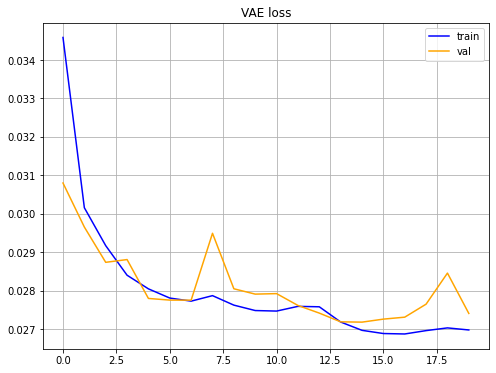

In [ ]:
plot_losses(train_losses[-40:], val_losses[-40:], 8, 6, 'AE_noisy Loss')

**один блок conv_transpose2d**

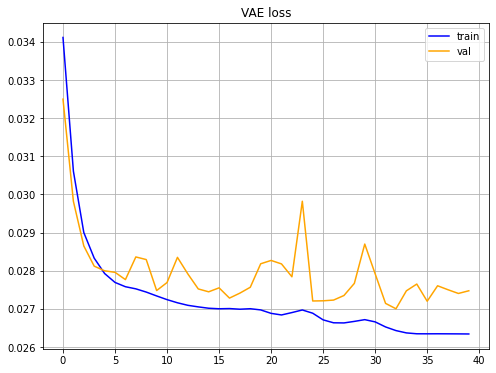

In [ ]:
plot_losses(train_losses[-40:], val_losses[-40:], 8, 6, 'AE_noisy Loss')

**смотрим результат**

In [ ]:
idx_rand = np.random.choice(all_photos.shape[0], 10)

In [ ]:
photos_noisy = torch.FloatTensor(np.rollaxis(all_photos_noisy, 3, 1)[idx_rand]).to(device)

In [ ]:
ae_noisy.eval()
photos_denoise = ae_noisy(photos_noisy).view(-1, 3, 64, 64).permute(0, 2, 3, 1).detach().cpu().numpy()

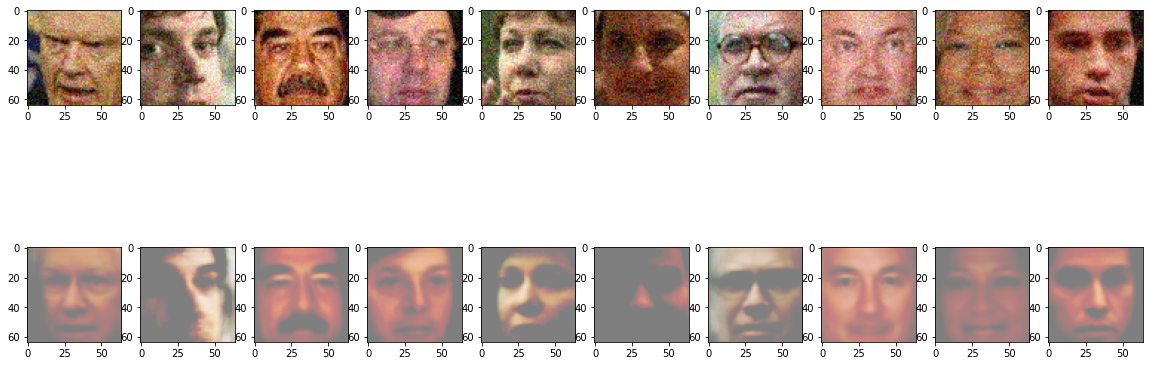

In [ ]:
plt.figure(figsize=(20, 8))

for i, (img, img_denoise) in enumerate(zip(all_photos_noisy[idx_rand], photos_denoise)):
  plt.subplot(2, 10, i+1)
  plt.imshow(img)
  plt.subplot(2, 10, i+1+10)
  plt.imshow(img_denoise)

#Image Retrieval

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них NearestNeighbors
3. Берем картинку из тестового датасета, с помощью AE получаем ее латентный вектор
4. Ищем с помощью обученного NearestNeighbors ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем.

In [ ]:
import gc
gc.collect()

26

In [ ]:
torch.cuda.empty_cache()

**здесь не хватает памяти, чтобы поместить весь тренировочный набор фотографий**

In [ ]:
autoencoder.eval()
latent_train = autoencoder.encoder(train_photos[:train_photos.shape[0]//2].to(device))

In [ ]:
latent_train.shape

torch.Size([5914, 32])

In [ ]:
# обучаем NearestNeighbors
from sklearn.neighbors import NearestNeighbors
nearest_n = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(latent_train.detach().cpu())

In [ ]:
def get_similar(image, n_neighbors=10):
  # функция, которая берет тестовый image и с помощью метода kneighbours ищет ближайшие векторы

  code = autoencoder.encoder(image[None, :, :, :].to(device)).detach().cpu()
  (distances,), (idx,) = nearest_n.kneighbors(code, n_neighbors=n_neighbors)

  return distances, train_photos[idx]

In [ ]:
def show_similar(image):
  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[10,8])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

**результат**

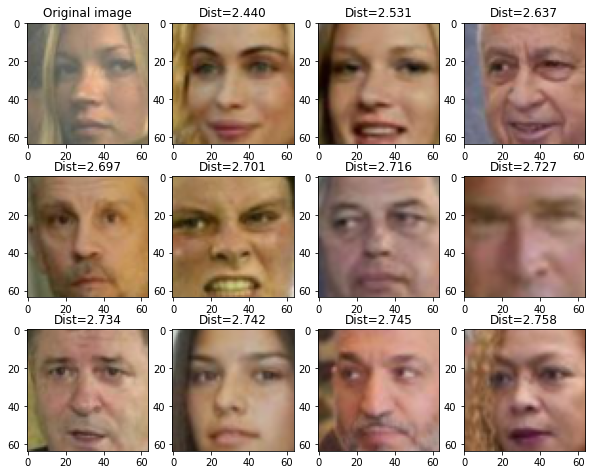

In [ ]:
show_similar(test_photos[14])

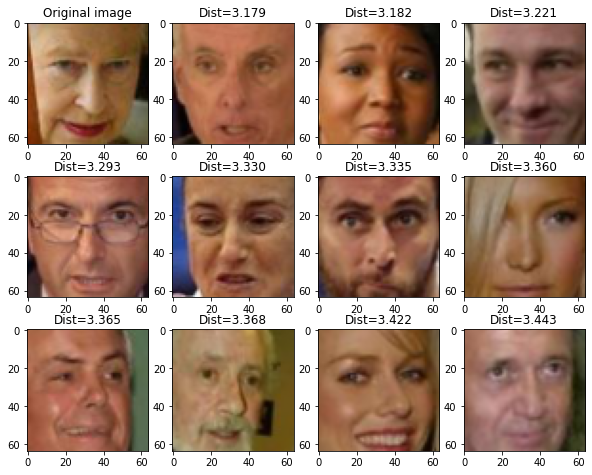

In [ ]:
show_similar(test_photos[29])

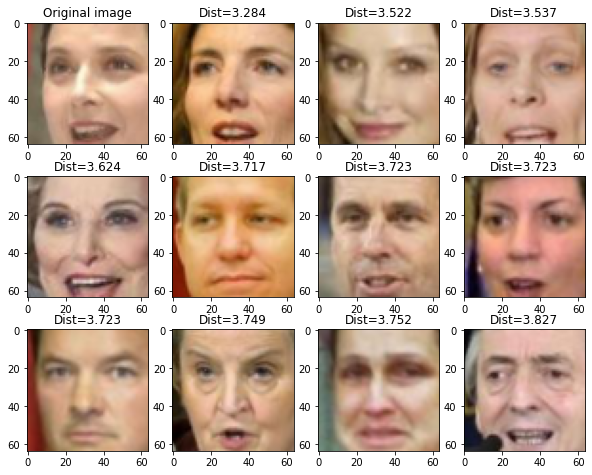

In [ ]:
show_similar(test_photos[140])

##*мои фото*

In [ ]:
from PIL import Image

In [ ]:
from torchvision import transforms

In [ ]:
img = Image.open('my_photo_resize.jpg')

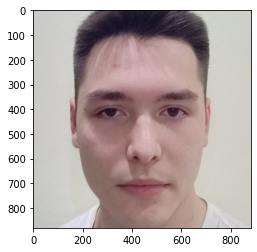

In [ ]:
plt.imshow(img)

In [ ]:
conver_tensor = transforms.Compose([transforms.Resize(64), transforms.ToTensor()])

In [ ]:
my_photo_tensor = conver_tensor(img)

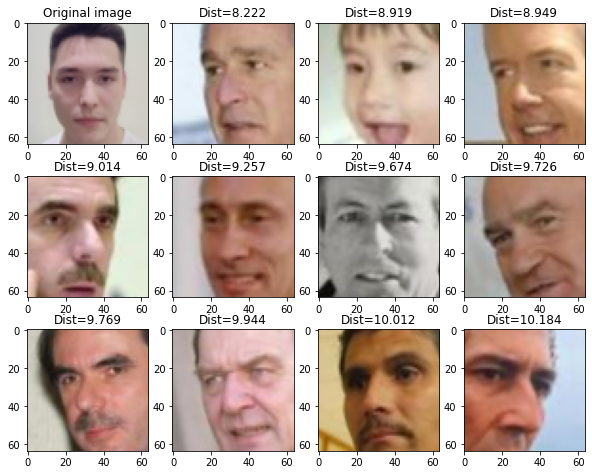

In [ ]:
show_similar(my_photo_tensor)

**:)**

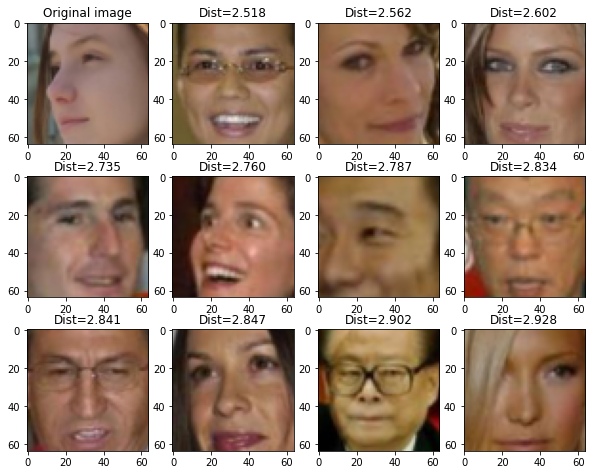

In [ ]:
show_similar(conver_tensor(Image.open('sister.jpg')))